# Recommender system for Steam

### This notebook is my personal study in recommendation systems, specifically using the collaborative filtering method with matrix factorization.

The dataset was designed for this purpose and can be found in https://www.kaggle.com/datasets/tamber/steam-video-games

Here is a great text about this theme: https://towardsdatascience.com/collaborative-filtering-and-embeddings-part-1-63b00b9739ce

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

seed = 33

## Analyzing and Cleaning the data

In [70]:
df = pd.read_csv("steam-200k.csv", names=["user_id", "game", "action", "hours", "other"])
df.head()

,user_id,game,action,hours,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


Delete rows where action = "purchase"

In [71]:
mask = df["action"] == "play"
df = df[mask]
df = df.drop(["other", "action"], axis=1)
df.head()

,user_id,game,hours
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


In [72]:
df = df.drop_duplicates(subset=["user_id", "game"])

Select only users who played at least 3 games

In [73]:
print(df.user_id.unique().shape)
buyers = df.drop(["hours"], axis=1).groupby(["user_id"]).count() >= 3
buyers = buyers.replace({False: np.nan}).dropna()
print(buyers.shape)
df = df.loc[df.user_id.isin(buyers.index)]
df.user_id.unique().shape

(11350,)
(3466, 1)


(3466,)

Just for curiosity, what's the most played games?

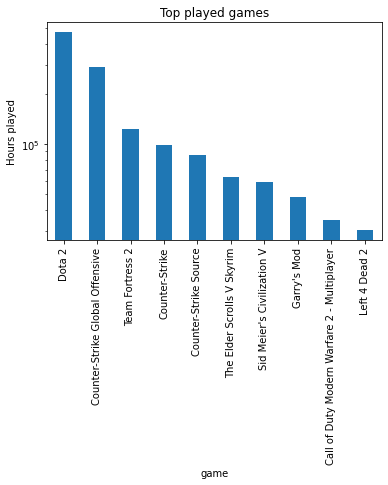

In [74]:
hours_by_game = df.drop(["user_id"], axis=1).groupby(["game"]).sum().sort_values(by="hours", ascending=False)
plt = hours_by_game.head(10).plot.bar(
    title="Top played games",
    logy=True,
    legend=False,
    ylabel="Hours played"
)

## Metrics

Here the goal is to transform "hours" in a more meaningful value

In [75]:
# Define "like" as the game that the user played more than 10 hours
df["Like"] = [1 if hour > 10 else 0 for hour in df["hours"]]
df.head()

,user_id,game,hours,Like
1,151603712,The Elder Scrolls V Skyrim,273.0,1
3,151603712,Fallout 4,87.0,1
5,151603712,Spore,14.9,1
7,151603712,Fallout New Vegas,12.1,1
9,151603712,Left 4 Dead 2,8.9,0


Get the sum of likes and average hours for each game

In [76]:
metrics = df.groupby(["game"]).mean().drop(["user_id", "Like"], axis=1).rename(columns={"hours":"Avg Hours"})
metrics["Likes"] = df.groupby(["game"])["Like"].sum()
metrics.head()

,Avg Hours,Likes
game,,
007 Legends,0.70,0
0RBITALIS,0.40,0
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),4.00,1
10 Second Ninja,2.95,0
"10,000,000",3.60,0


Filter the games which number of likes is greater than a threshold

In [77]:
threshold = metrics["Likes"].quantile(.85)
print(threshold)

print(df.shape[0])
metrics = metrics.loc[metrics["Likes"] > threshold]
df["to_drop"] = df["game"].isin(metrics.index).replace({False: np.nan})
df = df.dropna().drop("to_drop", axis=1)
print(df.shape[0])
metrics.head()

5.0
61268
44029


,Avg Hours,Likes
game,,
7 Days to Die,41.996809,48
APB Reloaded,70.867692,35
ARK Survival Evolved,90.293706,80
Ace of Spades,6.779412,16
AdVenture Capitalist,45.330769,51


In [78]:
df["Avg Hours for Game"] = df["game"].apply(lambda g: metrics["Avg Hours"].loc[g])
df.head()

,user_id,game,hours,Like,Avg Hours for Game
1,151603712,The Elder Scrolls V Skyrim,273.0,1,105.562938
3,151603712,Fallout 4,87.0,1,63.699375
5,151603712,Spore,14.9,1,25.291228
7,151603712,Fallout New Vegas,12.1,1,51.227341
9,151603712,Left 4 Dead 2,8.9,0,41.886842


Define a score based on hours played by the user and average hours

In [79]:
conditions = [
    df["hours"] < 0.25 * df["Avg Hours for Game"],
    (df["hours"] >= 0.25 * df["Avg Hours for Game"]) & (df["hours"] < 0.50 * df["Avg Hours for Game"]),
    (df["hours"] >= 0.50 * df["Avg Hours for Game"]) & (df["hours"] < 0.75 * df["Avg Hours for Game"]), 
    (df["hours"] >= 0.75 * df["Avg Hours for Game"]) & (df["hours"] < 1.00 * df["Avg Hours for Game"]), 
    (df["hours"] >= 1.00 * df["Avg Hours for Game"]) & (df["hours"] < 1.25 * df["Avg Hours for Game"]), 
    (df["hours"] >= 1.25 * df["Avg Hours for Game"]) & (df["hours"] < 1.50 * df["Avg Hours for Game"]),
    df["hours"] >= 1.50 * df["Avg Hours for Game"]
]

scores = list(range(1, len(conditions)+1))
scores

[1, 2, 3, 4, 5, 6, 7]

In [80]:
df["Rating"] = np.select(conditions, scores)
df.head()

,user_id,game,hours,Like,Avg Hours for Game,Rating
1,151603712,The Elder Scrolls V Skyrim,273.0,1,105.562938,7
3,151603712,Fallout 4,87.0,1,63.699375,6
5,151603712,Spore,14.9,1,25.291228,3
7,151603712,Fallout New Vegas,12.1,1,51.227341,1
9,151603712,Left 4 Dead 2,8.9,0,41.886842,1


## Illustrating matrix factorization method purpose

The algorithm tries to fill the NaN fields

In [81]:
# matrix = df.pivot(index="user_id", columns="game", values="hours")
matrix = df.pivot(index="user_id", columns="game", values="Rating")
soma0 = matrix.sum(axis=0)
soma1 = matrix.sum(axis=1)
matrix = matrix[soma0.sort_values(ascending=False).index]
matrix = matrix.loc[soma1.sort_values(ascending=False).index]
matrix.head()

game,Counter-Strike Global Offensive,Team Fortress 2,Dota 2,Unturned,The Elder Scrolls V Skyrim,Left 4 Dead 2,Garry's Mod,Portal 2,Terraria,Portal,...,Baldur's Gate Enhanced Edition,Dragon Nest Europe,Tom Clancy's Rainbow Six Siege,Wings of Prey,F1 2012,Blood Bowl Chaos Edition,Farming Simulator 2011,Pro Evolution Soccer 2015,The LEGO Movie - Videogame,Baldur's Gate II Enhanced Edition
user_id,,,,,,,,,,,,,,,,,,,,,
26762388,2.0,1.0,3.0,NaN,7.0,1.0,2.0,7.0,7.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48798067,7.0,1.0,1.0,1.0,5.0,5.0,5.0,NaN,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49893565,1.0,7.0,7.0,4.0,4.0,7.0,7.0,6.0,7.0,5.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10599862,1.0,1.0,1.0,NaN,7.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,7.0,NaN,1.0
17530772,NaN,1.0,1.0,NaN,5.0,7.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Encode data

In [82]:
user2idx = { u: i for i, u in enumerate(df.user_id.unique())}
game2idx = { g: i for i, g in enumerate(df.game.unique())}

idx2user = { i: u for u, i in user2idx.items()}
idx2game = { i: g for g, i in game2idx.items()}

df["user_idx"] = df["user_id"].apply(lambda u: user2idx[u])
df["game_idx"] = df["game"].apply(lambda g: game2idx[g])

lean_df = pd.DataFrame(df[["user_idx", "game_idx", "Rating"]])
# lean_df = pd.DataFrame(df[["user_idx", "game_idx", "hours"]])
lean_df = lean_df.sample(frac=1, random_state=seed).reset_index(drop=True)

lean_df

,user_idx,game_idx,Rating
0,456,158,7
1,889,213,7
2,3026,117,1
3,506,283,7
4,1965,268,7
...,...,...,...
44024,2091,478,5
44025,44,102,6
44026,2996,67,1
44027,194,289,1


## Split data

In [83]:
frac = 0.20

k = int(np.ceil(lean_df.shape[0] * frac))
train_df = lean_df[k:]
test_df = lean_df[:k]
print(train_df.shape)
print(test_df.shape)

(35223, 3)
(8806, 3)


## Create model

In [84]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=50):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        self.user_bias.weight.data.uniform_(-0.01, 0.01)
        self.item_bias.weight.data.uniform_(-0.01, 0.01)

    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        return (U*V).sum(1) + b_u + b_v
        # return (U*V).sum(1)

In [85]:
model = MF(
    num_users=lean_df.user_idx.unique().size,
    num_items=lean_df.game_idx.unique().size,
    emb_size=500
)
model

MF(
  (user_emb): Embedding(3446, 500)
  (item_emb): Embedding(534, 500)
  (user_bias): Embedding(3446, 1)
  (item_bias): Embedding(534, 1)
)

## Train the model

In [86]:
epochs = 400

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.MSELoss()

In [87]:
def get_test_precision(model):
  precision = []
  games_t = torch.LongTensor(lean_df.game_idx.unique())
  model.eval()
  for user in test_df.user_idx.unique():
    user_t = torch.tensor([user])
    prediction = model(user_t, games_t)
    sorted_idx = prediction.argsort(descending=True)
    prediction = prediction[sorted_idx]
    recommendation = lean_df.game_idx.unique()[sorted_idx][:10]
    user_games = lean_df.loc[lean_df.user_idx == user, ["game_idx"]].values.flatten()[:10]
    user_games = np.pad(user_games, (0, 10 - user_games.size), 'constant', constant_values=-1)
    p = len(set(user_games) & set(recommendation)) / float(10)
    precision.append(p)
  return np.array(precision).mean()

def get_test_loss(model):
    model.eval()
    users = torch.LongTensor(test_df.user_idx.values)
    games = torch.LongTensor(test_df.game_idx.values)
    # ratings = torch.FloatTensor(test_df.hours.values)
    ratings = torch.FloatTensor(test_df.Rating.values)
    prediction = model(users, games)
    loss = loss_fn(prediction, ratings)
    return loss.item()

In [88]:
train_loss = []
test_loss = []

for i in range(epochs):
    # get tensors
    users = torch.LongTensor(train_df.user_idx.values)
    games = torch.LongTensor(train_df.game_idx.values)
    ratings = torch.FloatTensor(train_df.Rating.values)
    # ratings = torch.FloatTensor(train_df.hours.values)

    model.train()
    prediction = model(users, games) # calls forward from model
    loss = loss_fn(prediction, ratings)
    train_loss.append(loss.item())

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    tloss = get_test_loss(model=model)
    test_loss.append(tloss)
    if i % 100 == 0:
        p = get_test_precision(model)
        print("train loss %.3f test loss %.3f test precision %.3f" % (loss.item(), tloss, p))
print("train loss %.3f test loss %.3f test precision %.3f" % (loss.item(), tloss, p))

train loss 12.191 test loss 12.180 test precision 0.010
train loss 4.035 test loss 5.217 test precision 0.005
train loss 3.284 test loss 5.229 test precision 0.032
train loss 1.433 test loss 5.290 test precision 0.112
train loss 0.355 test loss 5.443 test precision 0.112


Probably there is overfit because of the increase in test loss

In [89]:
plt.plot(range(epochs), train_loss, test_loss)
plt.legend(["train loss", "test loss"])

## Test Results

In [90]:
def recommendations_for(user_idx):
    user_x = torch.tensor([user_idx])
    games = torch.LongTensor(lean_df.game_idx.unique())
    prediction = model(user_x, games)
    sorted_idx = prediction.argsort(descending=True)
    prediction = prediction[sorted_idx]
    recommendation = lean_df.game_idx.unique()[sorted_idx]
    recommendation = [idx2game[idx] for idx in recommendation]
    return pd.DataFrame(prediction.tolist(), recommendation, columns=["Prediction"])

In [91]:
lean_df["game"] = lean_df.game_idx.apply(lambda i: idx2game[i])

In [92]:
for i in range(5, 600, 25):
  print(recommendations_for(i).head(10), lean_df.sort_values(by=["Rating"], ascending=False).loc[lean_df.user_idx == i, ["Rating", "game"]].head(), sep="\n\n")
  # print(recommendations_for(i).head(10), lean_df.sort_values(by=["hours"], ascending=False).loc[lean_df.user_idx == i, ["hours", "game"]].head(), sep="\n\n")
  print("=-=-=-=-=-=-=-=-=-=-=-=-=-=\n")

                                                    Prediction
Dota 2                                                0.940199
TERA                                                  0.926261
Fable Anniversary                                     0.810698
Shadow Warrior                                        0.736908
Football Manager 2012                                 0.736769
NARUTO SHIPPUDEN Ultimate Ninja STORM Revolution      0.731491
Assassin's Creed Brotherhood                          0.721141
This War of Mine                                      0.720492
STAR WARS Knights of the Old Republic II The Si...    0.706928
Resident Evil 5 / Biohazard 5                         0.702163

       Rating         game
685         3  Tomb Raider
29238       1       Dota 2
21027       1         TERA
=-=-=-=-=-=-=-=-=-=-=-=-=-=

                        Prediction
Starbound                 6.258677
DayZ                      3.712574
Fable Anniversary         2.970772
Beat Hazard               2.8

In [93]:
get_test_precision(model)

0.14703525641025642

## Convert to CoreML

In [94]:
!pip install coremltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
import coremltools as ct

For now, the inputs are user and game index and the output is the predicted rating for this combination

In [96]:
model.eval()

u_input = torch.randint(0, lean_df.user_idx.unique().size, (1,))
v_input = torch.randint(0, lean_df.game_idx.unique().size, (1,))

example_input = (u_input, v_input)

traced_model = torch.jit.trace(model, example_input)
out = traced_model(*example_input)
out

tensor([2.5514], grad_fn=<AddBackward0>)

In [97]:
ct_model = ct.convert(
    traced_model,
    inputs=[
        ct.TensorType(shape=u_input.shape, dtype=np.int32),
        ct.TensorType(shape=v_input.shape, dtype=np.int32)
    ]
)

ct_model.save("recommender.mlmodel")

Running MIL Common passes:   0%|          | 0/34 [00:00<?, ? passes/s]/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '34', of the source model, has been renamed to 'var_34' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 20/20 [00:00<00:00, 119.62 ops/s]
